In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [3]:
import tensorflow as tf
import numpy as np




In [4]:
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt

In [5]:

dataset_path = r'C:\Users\pc\OneDrive\Desktop\nit rkl\Alzheimer_s Dataset - Copy\train'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

# apply glob module to retrieve files/pathnames  

mri_path = os.path.join(dataset_path, CLASSES[1], '*')
mri_path = glob.glob(mri_path)

In [6]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=dataset_path, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

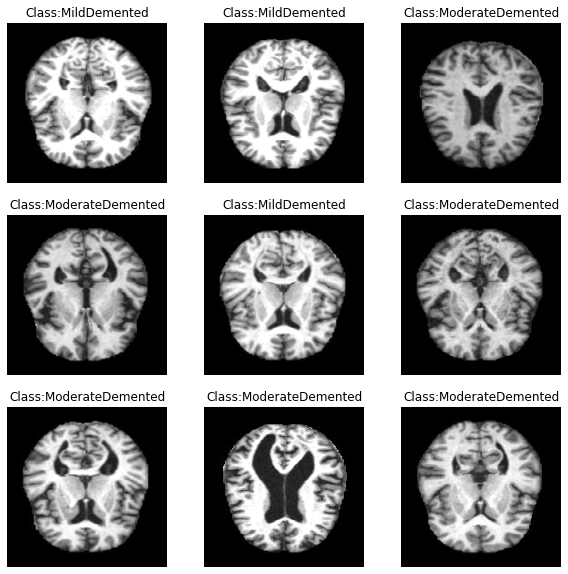

In [8]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [9]:

train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


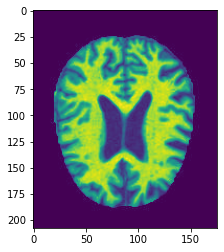

In [12]:
image = io.imread(mri_path[4])  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

In [19]:
# importing libraries
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import skimage.color as scc

C:\Users\pc\AppData\Local\Temp/ipykernel_7480/2257650838.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_image = scc.rgb2gray(image)


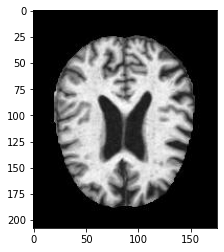

In [20]:
#normalization
gray_image = scc.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

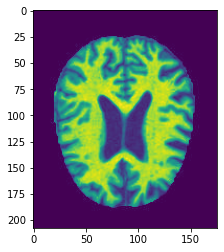

In [21]:
norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)

In [22]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [31]:
train_data.shape


(8192, 176, 176, 3)

In [32]:
val_data.shape

(2048, 176, 176, 3)

In [34]:
test_data.shape

(2560, 176, 176, 3)

In [35]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [36]:
for layer in inception_model.layers:
    layer.trainable=False

In [37]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [38]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [39]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [41]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 10

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
256/256 [==============================] - 337s 1s/step - loss: 1.3949 - acc: 0.4081 - auc: 0.6808 - f1_score: 0.4042 - val_loss: 0.8340 - val_acc: 0.5981 - val_auc: 0.8668 - val_f1_score: 0.5873 - lr: 0.0010
Epoch 2/10
256/256 [==============================] - 340s 1s/step - loss: 0.9411 - acc: 0.5629 - auc: 0.8360 - f1_score: 0.5584 - val_loss: 0.6740 - val_acc: 0.6743 - val_auc: 0.9151 - val_f1_score: 0.6628 - lr: 0.0010
Epoch 3/10
256/256 [==============================] - 328s 1s/step - loss: 0.7922 - acc: 0.6404 - auc: 0.8858 - f1_score: 0.6341 - val_loss: 0.6180 - val_acc: 0.7070 - val_auc: 0.9275 - val_f1_score: 0.6931 - lr: 0.0010
Epoch 4/10
256/256 [==============================] - 330s 1s/step - loss: 0.7299 - acc: 0.6669 - auc: 0.9034 - f1_score: 0.6629 - val_loss: 0.5730 - val_acc: 0.7466 - val_auc: 0.9393 - val_f1_score: 0.7420 - lr: 0.0010
Epoch 5/10
256/256 [==============================] - 325s 1s/step - loss: 0.6788 - acc: 0.7000 - auc: 0.9162 - f1_score

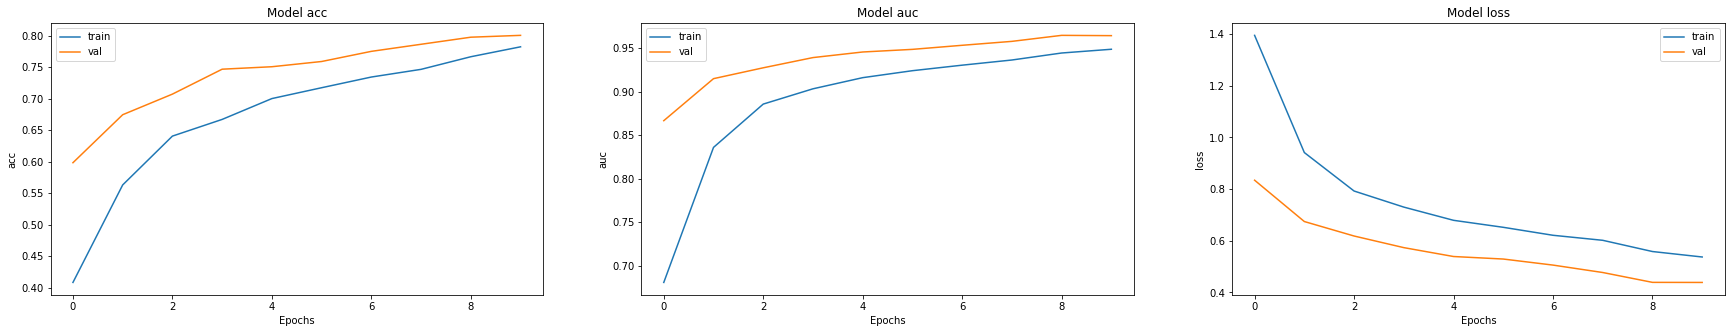

In [42]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [43]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 85s 1s/step - loss: 0.4581 - acc: 0.7918 - auc: 0.9609 - f1_score: 0.7895
Testing Accuracy: 79.18%
